## 現場で使える異常検知基礎講座 通し課題
- 気象データを使用して、異常検知を行う。

### 発表内容
+ **異常検知モデルで検知したい異常**

    昨今、異常気象と言われているが本当に異常気象になっていっているのか。


+ **使用したデータ**

    2008年から2018年10月31日の大阪の最高気温と最低気温。


+ **前処理方法**
    
    気象庁のHPからダウンロードしたデータから不要なヘッダーや品質情報、均質番号の情報を削る。


+ **異常検知モデルのアプローチ**
    
    検討中。


+ **性能評価の方法と結果**

    検討中。


+ **構築した異常検知モデルの社会的意義**

   

+ **通し課題に取り組んだ感想**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, RadiusNeighborsClassifier

### データの読み込み

In [2]:
# CSVを読み込む（不要なヘッダー類は削除して読み込む）
df_old_years = pd.read_csv("data/data_OSK_2008-2017.csv",encoding="SHIFT-JIS",skiprows=[0,1,2,4,5])
df_curr_year = pd.read_csv("data/data_OSK_2018-1031.csv",encoding="SHIFT-JIS",skiprows=[0,1,2,4,5])

# データをひとつにまとめる
df_full_years = pd.concat([df_old_years, df_curr_year], ignore_index=True)

# データをちょっと見てみる
df_full_years.head()

,年月日,最低気温(℃),最低気温(℃).1,最低気温(℃).2,最高気温(℃),最高気温(℃).1,最高気温(℃).2,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,2008/1/1,2.4,8,1,7.0,8,1,4.3,8,1
1,2008/1/2,0.9,8,1,9.5,8,1,5.4,8,1
2,2008/1/3,2.3,8,1,10.6,8,1,6.9,8,1
3,2008/1/4,3.1,8,1,12.1,8,1,6.9,8,1
4,2008/1/5,2.7,8,1,11.8,8,1,7.2,8,1


In [3]:
# 品質情報,均質番号の列は除外する
# "最低気温(℃).1", "最低気温(℃).2", "最高気温(℃).1", "最高気温(℃).2", "平均気温(℃).1", "平均気温(℃).2"
df_use_data = df_full_years.drop(df_full_years.columns[[2,3,5,6,8,9]], axis="columns")

# データをちょっと見てみる
df_use_data.head()

,年月日,最低気温(℃),最高気温(℃),平均気温(℃)
0,2008/1/1,2.4,7.0,4.3
1,2008/1/2,0.9,9.5,5.4
2,2008/1/3,2.3,10.6,6.9
3,2008/1/4,3.1,12.1,6.9
4,2008/1/5,2.7,11.8,7.2


In [4]:
# 欠損などがないかを見てみる
df_use_data.describe()

,最低気温(℃),最高気温(℃),平均気温(℃)
count,3957.000000,3957.000000,3957.000000
mean,13.644478,21.456937,17.192317
std,8.499637,8.842985,8.412541
min,-3.500000,3.200000,0.100000
25%,5.700000,13.300000,9.400000
50%,13.800000,22.000000,17.700000
75%,21.000000,28.800000,24.300000
max,29.200000,38.400000,32.700000


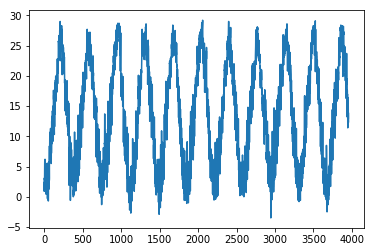

In [5]:
# 最低気温を見てみる
plt.plot(df_use_data["最低気温(℃)"])
plt.show()

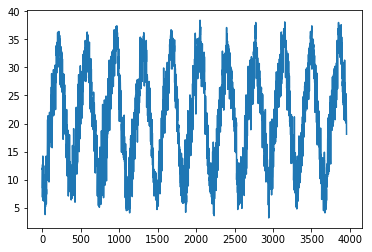

In [6]:
# 最高気温を見てみる
plt.plot(df_use_data["最高気温(℃)"])
plt.show()

### 分析してみる

#### その１．指数加重移動平均

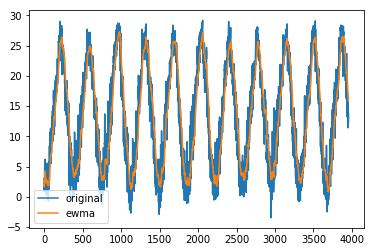

In [7]:
# 指数加重移動平均をまずは見てみる
ewm_mean = df_use_data["最低気温(℃)"].ewm(span=30).mean()  

fig, ax = plt.subplots()
plt.plot(df_use_data["最低気温(℃)"], label='original')
plt.plot(ewm_mean, label='ewma')
plt.legend()

In [8]:
# グラフ描画
def plot_outlier(ts, ewm_span=30, threshold=2.0):
    assert type(ts) == pd.Series
    fig, ax = plt.subplots()

    ewm_mean = ts.ewm(span=ewm_span).mean()  # 指数加重移動平均
    ewm_std = ts.ewm(span=ewm_span).std()  # 指数加重移動標準偏差
    ax.plot(ts, label='original', color='orange')
    ax.plot(ewm_mean, label='ewma', color='green')

    # 標準偏差から threshold 倍以上外れているデータを外れ値としてプロットする
    ax.fill_between(ts.index,
                    ewm_mean - ewm_std * threshold,
                    ewm_mean + ewm_std * threshold,
                    alpha=0.2)
    outlier = ts[(ts - ewm_mean).abs() > ewm_std * threshold]
    ax.scatter(outlier.index, outlier, label='outlier', color='red')
    print(outlier.shape) # 個数
    ax.legend()
    return fig



(63,)


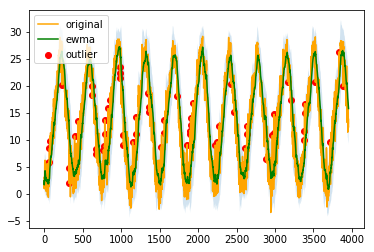

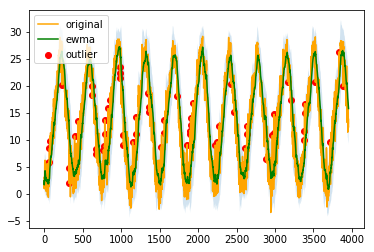

In [9]:

plot_outlier(df_use_data["最低気温(℃)"])

(85,)


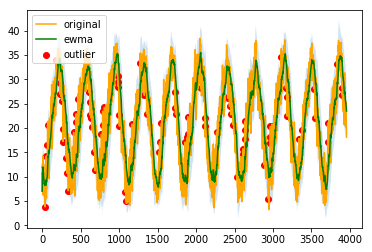

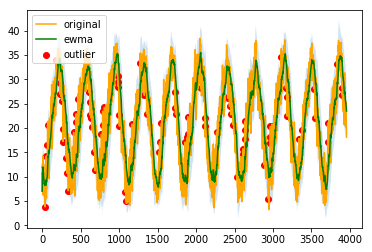

In [10]:

plot_outlier(df_use_data["最高気温(℃)"])

#### その２．K近傍法（NearestNeighbors）

In [11]:
# データの形を変える
def embed(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) 
        emb = np.append( emb, tmp, axis=0)
    return emb

# ホテリングT2法
def calc_score(x, sigma):
    return (x/sigma)**2

# グラフ描画
def plot_neigh(data, validation_split=0.5, width=1, nk=1):
    split_line = np.floor(data.shape[0]*(1-validation_split)).astype(np.int)

    # print(split_line)

    train_data = data.iloc[0:split_line]
    test_data = data.iloc[split_line+1:data.shape[0]]

    # print(train_data, test_data.shape)

    train = embed(train_data, width)
    test = embed(test_data, width)

    # print(train, train_data)

    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]

    d = calc_score(d, d.std(ddof=0))

    # プロット
    test_for_plot = data.iloc[split_line+width+1:data.shape[0]].reset_index().drop(columns="index") #data.iloc[split_line+1:data.shape[0], 1].reset_index().drop(columns="index")
    # print(test_data)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    p1, = ax1.plot(d, '-b')
    ax1.set_ylabel('distance')
    #ax1.set_ylim(0, 1.2)
    p2, = ax2.plot(test_for_plot, '-g')
    ax2.set_ylabel('original')
    #ax2.set_ylim(0, 12.0)
    plt.title("Nearest Neighbors")
    ax1.legend([p1, p2], ["distance", "original"])
    #plt.savefig('./results/knn.png')
    plt.show()

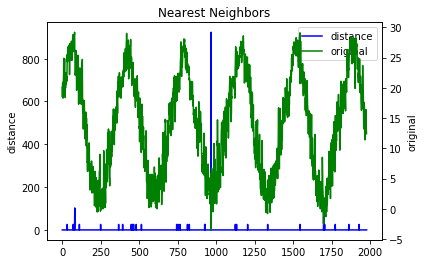

In [12]:
plot_neigh(df_use_data["最低気温(℃)"])

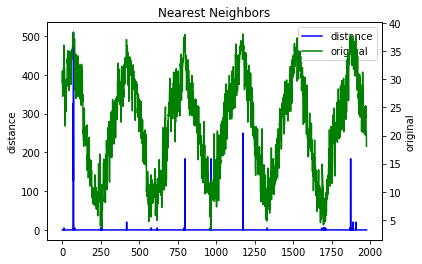

In [13]:
plot_neigh(df_use_data["最高気温(℃)"])